In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.grid'] = True

import numpy as np

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import torch

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
classes = [0, 1, 2, 3]
class_labels = ["electron","muon","photon","proton"]

In [3]:
def calculate_tpr_fpr(y_real, y_pred):
    """
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    """
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr
    
def get_all_roc_coordinates(y_real, y_proba):
    """
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    """
    tpr_list = [0]
    fpr_list = [0]
    resolution = 50
    
    for i in range(resolution):
        threshold = i / resolution
#         threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
        
    return tpr_list, fpr_list

def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    """
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    """
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
def plot_overlayed_roc_curve(classes, labels, predictions, class_labels, odir, label = '', ax = None, figsize=(9, 9), ncol=2):
    """
    Plots overlayed ROC curves and returns a list of AUC.
    
    Args:
        classes: The classes used in classification. Must match with the predictions and labels.
                 i.e., if predictions consists of [..., 1, 3, 2, 1, 4, ...], then your classes cannot be ['photon', 'hadron', 'lepton']
        labels: The list of labels.
        predictions: The list of predicted classes. First dimension should match with the dimension of labels
        class_labels: List of actual names of the classes (instead of 0, 1, ...)
    Return:
        roc_auc_ovr: Dictionary of AUC, one for each class
    """
#     assert labels.size() == predictions[:, 0].size()
    if predictions.type() == 'torch.cuda.FloatTensor':
        predictions = predictions.cpu()
        
    if ax == None:
        fig, ax = plt.subplots(figsize=figsize)
    
    roc_auc_ovr = {}
    for i in range(len(classes)):
        c = classes[i]
        y_real = [1 if y == c else 0 for y in labels]
        y_proba = predictions[:, i]
        tpr, fpr = get_all_roc_coordinates(y_real, y_proba)
        
        # Calculates the ROC AUC
        roc_auc_ovr[c] = roc_auc_score(y_real, y_proba.detach())
        print(roc_auc_ovr[c])
        
        ax.plot(fpr, tpr, label = f"{class_labels[i]}: AUC_ovr = {roc_auc_ovr[c]:.3f}")

    # plot the 50/50 lines
    x = np.linspace(0, 1, 10)
    Y = x
    plt.plot(x, Y, color='k', linestyle='dashed')
    # set limits and labels on axes
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    ax.legend(loc='lower right', shadow=False, ncol=ncol)
    plt.title(f"ROC Curve OvR for {label}")
    plt.show()
    fig.savefig("%s/roc_curve_%s.pdf" % (odir, label))
    fig.savefig("%s/roc_curve_%s.png" % (odir, label))
    
    return roc_auc_ovr

In [66]:
label = "GraphConv_w_pos"
model_perf_loc = f"/ssl-jet-vol-v2/ssi_2023_if_1/models/model_performances/{label}"
train_losses = np.load(f"{model_perf_loc}/train_losses.npy")
val_losses = np.load(f"{model_perf_loc}/val_losses.npy")
val_accs = np.load(f"{model_perf_loc}/val_accs.npy")

FileNotFoundError: [Errno 2] No such file or directory: '/ssl-jet-vol-v2/ssi_2023_if_1/models/model_performances/GraphConv_w_pos/train_losses.npy'

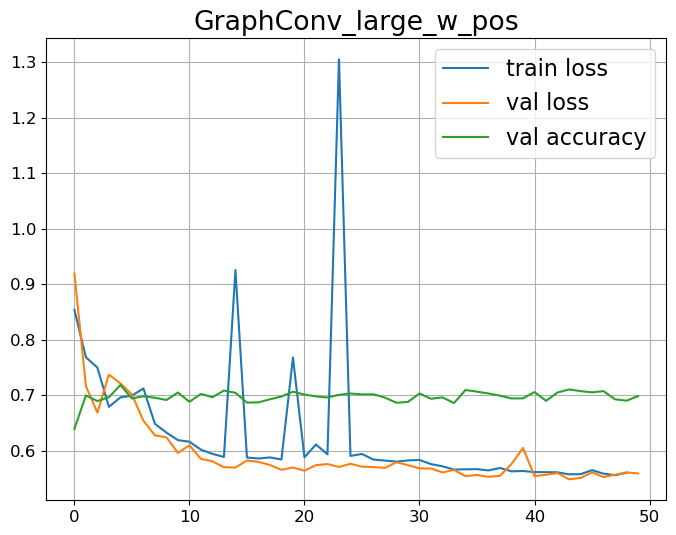

In [57]:

plt.plot(train_losses)
plt.plot(val_losses)
plt.plot(val_accs)
plt.legend(["train loss", "val loss", "val accuracy"])
plt.title(label)
plt.savefig(f"{model_perf_loc}/{label}_losses")

In [67]:
all_predictions = torch.load(f"{model_perf_loc}/predictions.pt")
all_predicted_probs = torch.load(f"{model_perf_loc}/predicted_probabilities.pt")
all_labels = torch.load(f"{model_perf_loc}/labels.pt")

0.9179758749333333
0.99826396
0.9201765509333333
0.9995019784


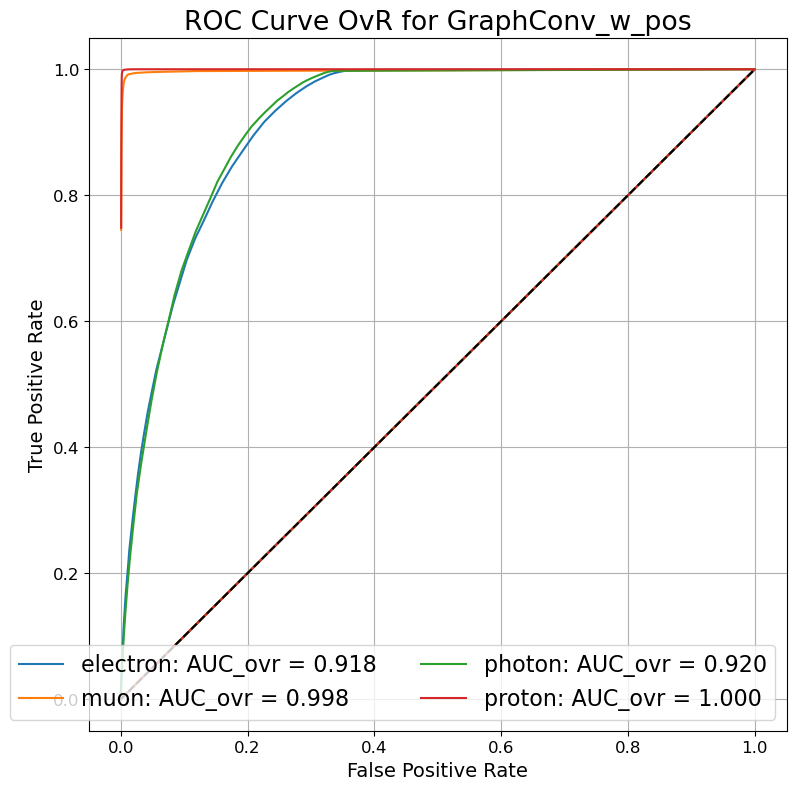

{0: 0.9179758749333333, 1: 0.99826396, 2: 0.9201765509333333, 3: 0.9995019784}

In [68]:
plot_overlayed_roc_curve(classes, all_labels, all_predicted_probs, class_labels, model_perf_loc, label = label)

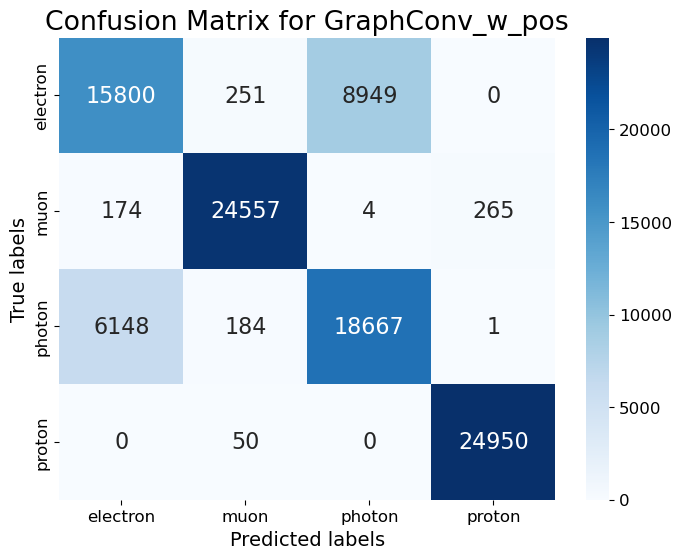

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Compute the confusion matrix
cm = confusion_matrix(all_labels.cpu(), all_predictions.cpu())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=class_labels, 
            yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix for {label}')
plt.savefig(f"{model_perf_loc}/{label}_confusion_matrix", dpi=300, bbox_inches='tight')
plt.show()
# plt.savefig(f"{model_perf_loc}/{label}_confusion_matrix")


In [70]:
mask = all_predictions != all_labels

In [71]:
misclassified = all_labels[mask]

In [72]:
miscl_dict = {0:0, 1:0, 2:0, 3:0}
for i in range(4):
    miscl_dict[i] = torch.eq(misclassified, i).sum().item()

In [73]:
miscl_dict

{0: 9200, 1: 443, 2: 6333, 3: 50}

In [74]:
label_dict = {0: "electron", 1:"muon", 2:"photon", 3:"proton"}

# Open a text file in write mode
with open(f"{model_perf_loc}/{label}_Accuracy.txt", "w") as f:
    f.write(f"Misclassification rates for {label} \n")
    for i in range(4):
        # Create the string to be written
        output_str = f"{label_dict[i]} misclassified: {miscl_dict[i]} / {(all_labels==i).sum().item()}. Rate {100 * miscl_dict[i] / (all_labels==i).sum().item():.2f}%\n"
        
        # Write to the file
        f.write(output_str)
        
        # Also print to the console if needed
        print(output_str)
    acc =  (1 - len(misclassified) / len(all_labels)) * 100
    f.write(f"Overall accuracy: {acc:.2f}%")
    print(f"Overall accuracy: {acc:.2f}%")


electron misclassified: 9200 / 25000. Rate 36.80%

muon misclassified: 443 / 25000. Rate 1.77%

photon misclassified: 6333 / 25000. Rate 25.33%

proton misclassified: 50 / 25000. Rate 0.20%

Overall accuracy: 83.97%


In [13]:
acc =  (1 - len(misclassified) / len(all_labels)) * 100
print(f"{acc:.2f}%")

85.92%


In [75]:
perf_dict = {}
perf_dict["vanilla"] = [56.01, 29.18, 78.4]
perf_dict["GATConv"] = [41.23, 34.71, 80.5]
perf_dict["GATConv_w_pos"] = [44.36, 22.47, 82.97]
perf_dict["GraphConv"] = [32.52, 31.18, 83.7]
perf_dict["GraphConv_w_pos"] = [36.8, 25.33, 83.97]
perf_dict["GraphConv_large"] = [31.61, 25.43, 85.51]
perf_dict["GraphConv_large_w_pos"] = [63.51, 47.77, 68.55]

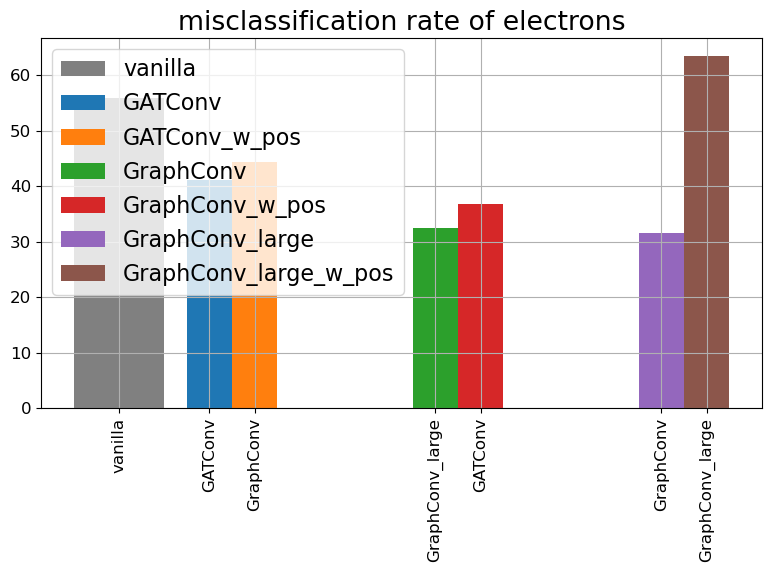

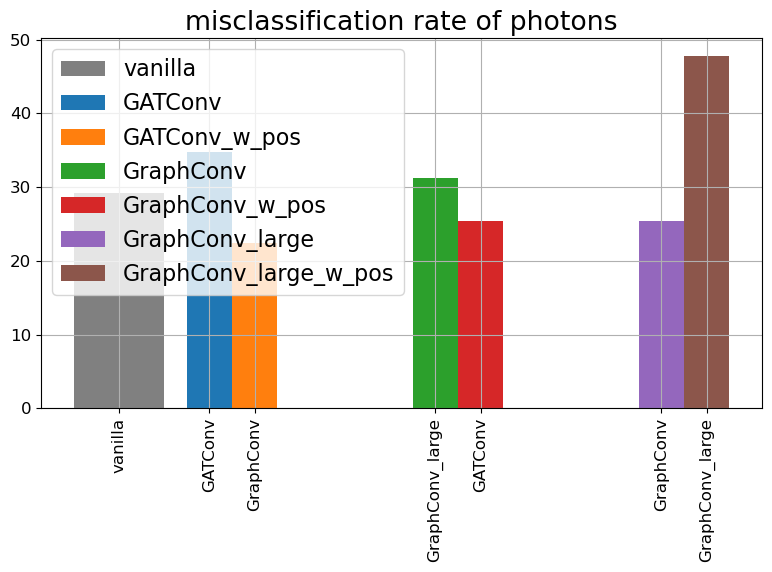

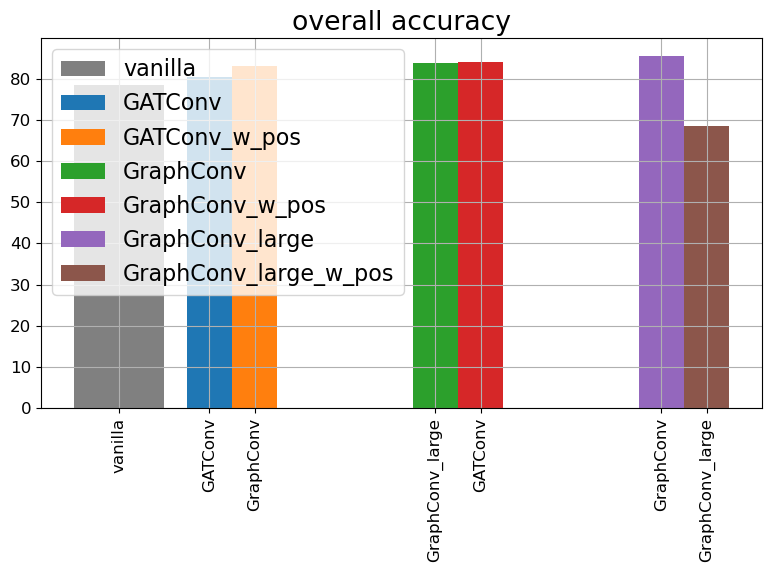

In [82]:
elem_name_lst = ["misclassification rate of electrons", "misclassification rate of photons", "overall accuracy"]
labels = list(perf_dict.keys())
del labels[0]  # Remove 'vanilla' from labels

# ... [rest of the code remains unchanged]

# Create plots for each element
for i in range(3):  # Since we have three elements in the list
    fig, ax = plt.subplots()
    
    # Vanilla bars
    ax.bar(0, perf_dict["vanilla"][i], label="vanilla", color='gray')
    
    # For the other items in the dictionary
    positions = [0]  # Start with the position for "vanilla"
    for j, label in enumerate(labels, start=1):
        if "_w_pos" in label:
            continue  # Skip to avoid duplicate pairs
        label_w_pos = label + "_w_pos"
        
        # Plot bars side by side
        ax.bar(j-0.2, perf_dict[label][i], width=0.4, label=label)
        ax.bar(j+0.2, perf_dict[label_w_pos][i], width=0.4, label=label_w_pos)
        positions.extend([j-0.2, j+0.2])  # Add positions for the plotted bars
    
    ax.set_title(f"{elem_name_lst[i]}")
    ax.set_xticks(positions)
    ax.set_xticklabels(["vanilla"] + [label for label in labels if "_w_pos" not in label] * 2, rotation=90)  # Adjust labels accordingly
    ax.legend()
    
    plt.tight_layout()
    plt.show()



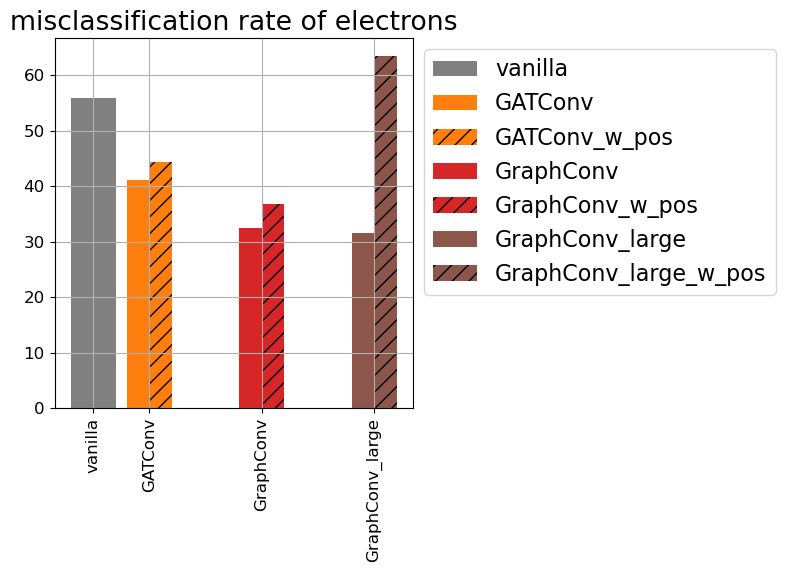

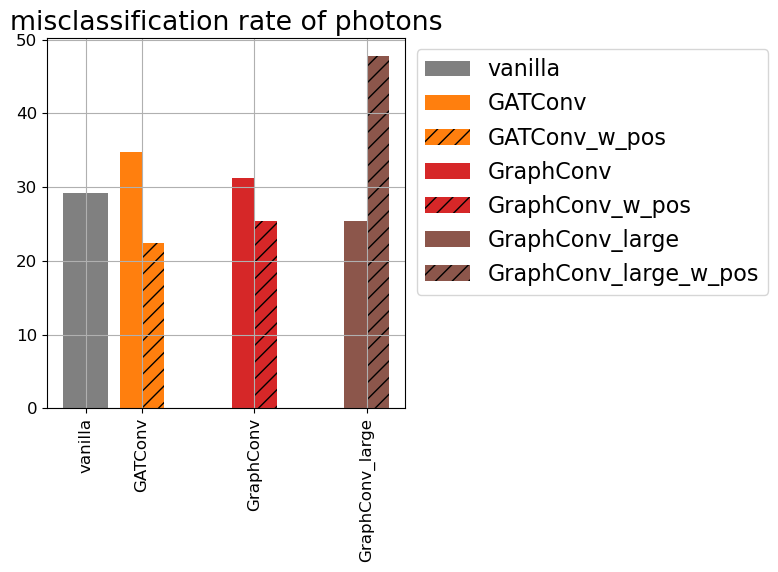

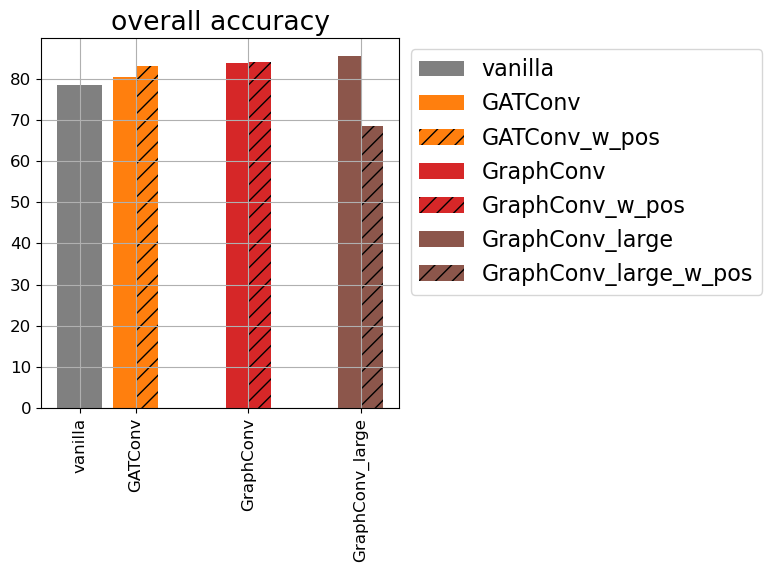

In [85]:
labels = [label for label in perf_dict if label != "vanilla"]

# Create plots for each element
for i in range(3):  # Since we have three elements in the list
    fig, ax = plt.subplots()
    
    # Vanilla bars
    ax.bar(0, perf_dict["vanilla"][i], label="vanilla", color='gray')
    
    # For the other items in the dictionary
    positions = [0]  # Start with the position for "vanilla"
    for j, label in enumerate(labels, start=1):
        if "_w_pos" in label:
            continue  # Skip to avoid duplicate pairs
        
        # Plot bars side by side
        ax.bar(j-0.2, perf_dict[label][i], width=0.4, label=label, color='C'+str(j))
        ax.bar(j+0.2, perf_dict[label+"_w_pos"][i], width=0.4, label=label+"_w_pos", color='C'+str(j), hatch="//")
        
        positions.append(j)  # Add position for the plotted bars
    
    ax.set_title(f"{elem_name_lst[i]}")
    ax.set_xticks(positions)
    ax.set_xticklabels(["vanilla"] + [label.replace("_w_pos", "") for label in labels if "_w_pos" not in label], rotation=90)  # Rotate the x-tick labels by 90 degrees
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
    
    plt.tight_layout()
    plt.savefig(f"/ssl-jet-vol-v2/ssi_2023_if_1/models/model_performances/{elem_name_lst[i]}.png")
    plt.show()


In [2]:
model_param_dict = {}
model_param_dict["vanilla GNN"] = [33796, 78.4]
model_param_dict["GATConv_w_pos"] = [68100, 82.97]
model_param_dict["GraphConv_w_pos"] = [67204, 83.97]
model_param_dict["GraphConv_large"] = [329860, 85.51]
model_param_dict["Baseline CNN"] = [37976650, 85.92]
model_param_dict["VGG 16"] = [107021252, 96.2]
model_param_dict["ResNet-152"] = [58152004, 95.9]
model_param_dict["CNN 1"] = [28328116, 86.06]
model_param_dict["CNN 2"] = [150884, 89.38]
model_param_dict["GNN 1"] = [5244, 85.05]
"""
vgg16 parameter = 107,021,252 
Accuracy = 0.962
Resnet152 = 58,152,004
Accuracy = 0.959
CNN1 parameter = 28328116 Accuracy = 0.86059
CNN2 parameter = 150884 Accuracy = 0.89381
GNN parameter = 3604 Accuracy = 0.81798
"""

'\nvgg16 parameter = 107,021,252 \nAccuracy = 0.962\nResnet152 = 58,152,004\nAccuracy = 0.959\nCNN1 parameter = 28328116 Accuracy = 0.86059\nCNN2 parameter = 150884 Accuracy = 0.89381\nGNN parameter = 3604 Accuracy = 0.81798\n'

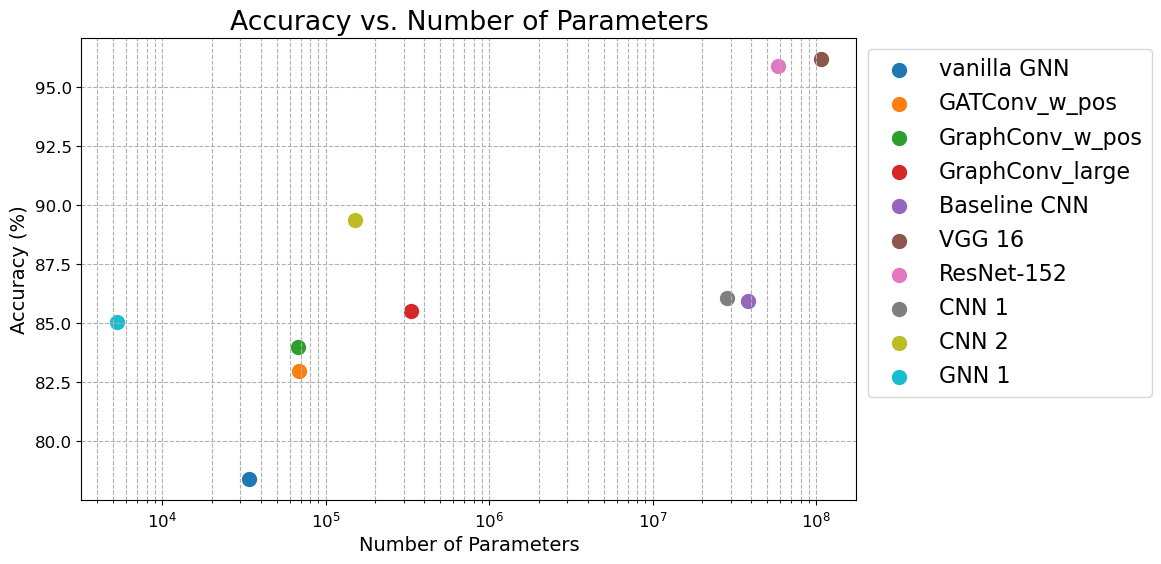

In [4]:
# Extracting parameters and accuracies
params = [model_param_dict[model][0] for model in model_param_dict]
accuracies = [model_param_dict[model][1] for model in model_param_dict]
labels = list(model_param_dict.keys())

# Create scatter plot
plt.figure(figsize=(10,6))
for i, label in enumerate(labels):
    plt.scatter(params[i], accuracies[i], label=label, s=100)

# Label the axes
plt.xlabel('Number of Parameters')
plt.ylabel('Accuracy (%)')
plt.xscale('log')  # Using a log scale for the x-axis due to wide range of values
plt.grid(True, which="both", ls="--")

# Provide a title
plt.title('Accuracy vs. Number of Parameters')

# Add a legend
plt.legend(loc='upper left', bbox_to_anchor=(1,1))


# Display the plot
plt.show()
